In [173]:
# import necessary libraries
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from ucimlrepo import fetch_ucirepo
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from itertools import product
from scipy.io import loadmat

# 3. Random Forest and one-class SVM for email spam classifier

In [3]:
# load in the data
spambase = fetch_ucirepo(id=94)
X = spambase.data.features.fillna(0)  # Fill missing values with 0
y = spambase.data.targets

In [4]:
# metadata 
print(spambase.metadata) 

{'uci_id': 94, 'name': 'Spambase', 'repository_url': 'https://archive.ics.uci.edu/dataset/94/spambase', 'data_url': 'https://archive.ics.uci.edu/static/public/94/data.csv', 'abstract': 'Classifying Email as Spam or Non-Spam', 'area': 'Computer Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 4601, 'num_features': 57, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['Class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1999, 'last_updated': 'Mon Aug 28 2023', 'dataset_doi': '10.24432/C53G6X', 'creators': ['Mark Hopkins', 'Erik Reeber', 'George Forman', 'Jaap Suermondt'], 'intro_paper': None, 'additional_info': {'summary': 'The "spam" concept is diverse: advertisements for products/web sites, make money fast schemes, chain letters, pornography...\n\nThe classification task for this dataset is to determine whether a given email is spam or not.\n\t\nOur collecti

In [5]:
# variable information 
print(spambase.variables)

                          name     role        type demographic  \
0               word_freq_make  Feature  Continuous        None   
1            word_freq_address  Feature  Continuous        None   
2                word_freq_all  Feature  Continuous        None   
3                 word_freq_3d  Feature  Continuous        None   
4                word_freq_our  Feature  Continuous        None   
5               word_freq_over  Feature  Continuous        None   
6             word_freq_remove  Feature  Continuous        None   
7           word_freq_internet  Feature  Continuous        None   
8              word_freq_order  Feature  Continuous        None   
9               word_freq_mail  Feature  Continuous        None   
10           word_freq_receive  Feature  Continuous        None   
11              word_freq_will  Feature  Continuous        None   
12            word_freq_people  Feature  Continuous        None   
13            word_freq_report  Feature  Continuous        Non

In [8]:
X.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.0,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.0,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.0,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.0,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.0,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191


In [9]:
y.head()

,Class
0,1
1,1
2,1
3,1
4,1


In [22]:
X.describe()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total
count,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,...,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000
mean,0.104553,0.213015,0.280656,0.065425,0.312223,0.095901,0.114208,0.105295,0.090067,0.239413,...,0.031869,0.038575,0.139030,0.016976,0.269071,0.075811,0.044238,5.191515,52.172789,283.289285
std,0.305358,1.290575,0.504143,1.395151,0.672513,0.273824,0.391441,0.401071,0.278616,0.644755,...,0.285735,0.243471,0.270355,0.109394,0.815672,0.245882,0.429342,31.729449,194.891310,606.347851
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.588000,6.000000,35.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.065000,0.000000,0.000000,0.000000,0.000000,2.276000,15.000000,95.000000
75%,0.000000,0.000000,0.420000,0.000000,0.380000,0.000000,0.000000,0.000000,0.000000,0.160000,...,0.000000,0.000000,0.188000,0.000000,0.315000,0.052000,0.000000,3.706000,43.000000,266.000000
max,4.540000,14.280000,5.100000,42.810000,10.000000,5.880000,7.270000,11.110000,5.260000,18.180000,...,10.000000,4.385000,9.752000,4.081000,32.478000,6.003000,19.829000,1102.500000,9989.000000,15841.000000


In [34]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=6740, shuffle=True)

# Build the CART model for the visualization in part 1 (pruned)
cart_model = DecisionTreeClassifier(random_state=6740, min_samples_leaf = 200)
cart_model.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=200, random_state=6740)

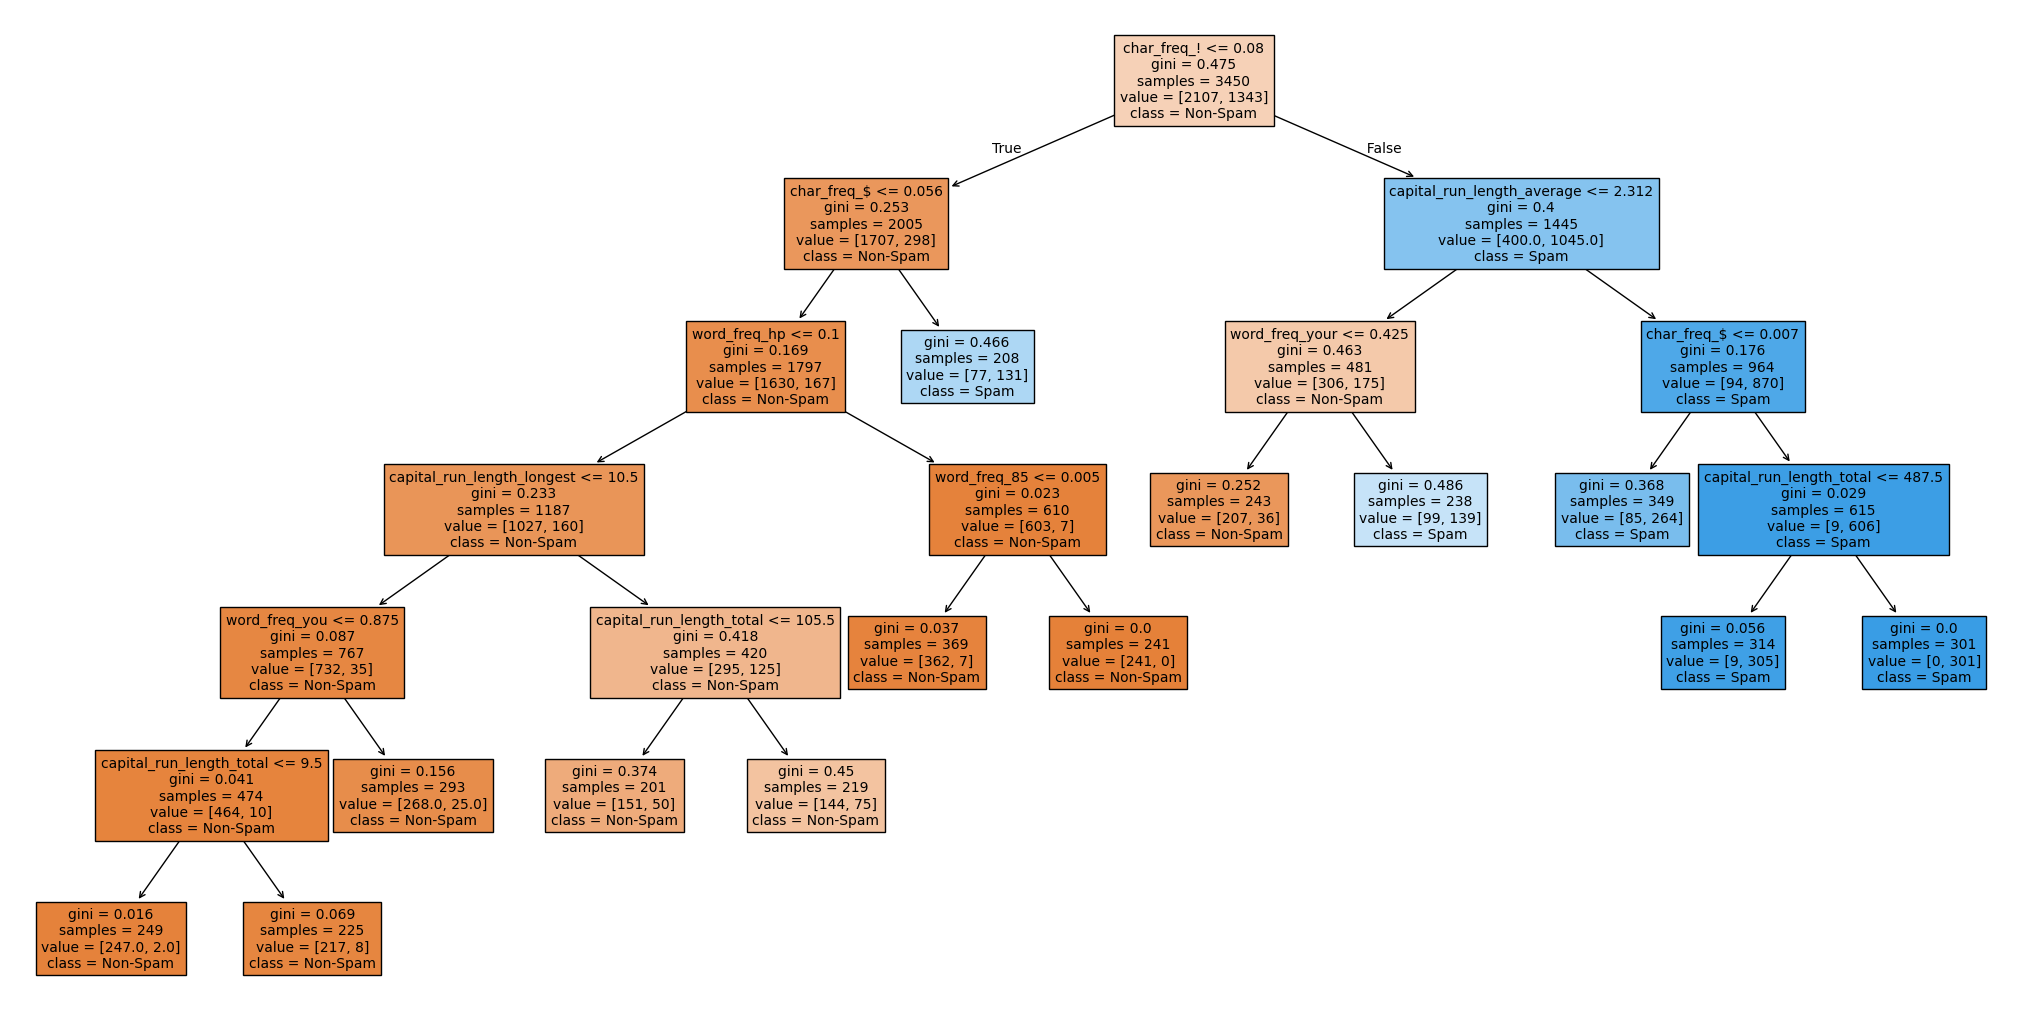

In [39]:
# Visualize the decision tree
plt.figure(figsize=(26, 13))
plot_tree(cart_model, filled = True, fontsize=10,feature_names=X.columns, class_names=['Non-Spam', 'Spam'])
plt.show()

In [41]:
# build the CART model for analysis (no pruning)
cart = DecisionTreeClassifier(random_state=6740)
cart.fit(X_train, y_train)

cart_test_error = 1 - cart.score(X_test, y_test)

In [168]:
cart_test_error

0.09991311902693312

In [47]:


n_trees_range = range(1, 101)
rf_test_errors = []

# Loop through different numbers of trees to find test error
for n_trees in n_trees_range:
    rf_model = RandomForestClassifier(n_estimators=n_trees, random_state=6740)
    rf_model.fit(X_train, y_train.values.ravel())
    rf_test_errors.append(1 - rf_model.score(X_test, y_test.values.ravel()))
    print(n_trees)



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


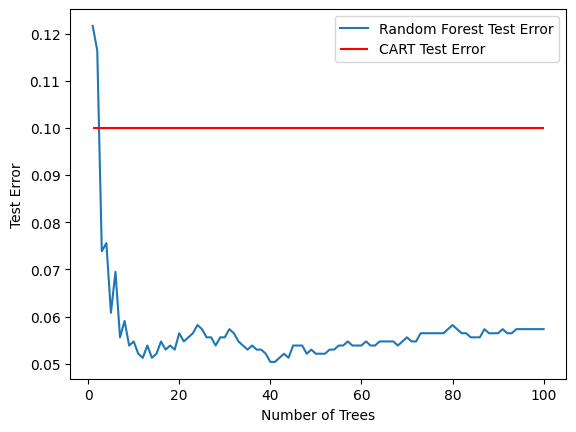

In [48]:
# Plot test errors
plt.plot(n_trees_range, rf_test_errors, label="Random Forest Test Error")
plt.hlines(cart_test_error, xmin=1, xmax=100, colors='red', label="CART Test Error")
plt.xlabel("Number of Trees")
plt.ylabel("Test Error")
plt.legend()
plt.show()

In [50]:
oob_errors = []
test_errors = []

# Loop through different values for max_features
for nu in range(1, X.shape[1] + 1):
    rf_model = RandomForestClassifier(n_estimators=100, max_features=nu, oob_score=True, random_state=6740)
    rf_model.fit(X_train, y_train.values.ravel())
    oob_errors.append(1 - rf_model.oob_score_)
    test_errors.append(1 - rf_model.score(X_test, y_test.values.ravel()))
    print(nu)



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57


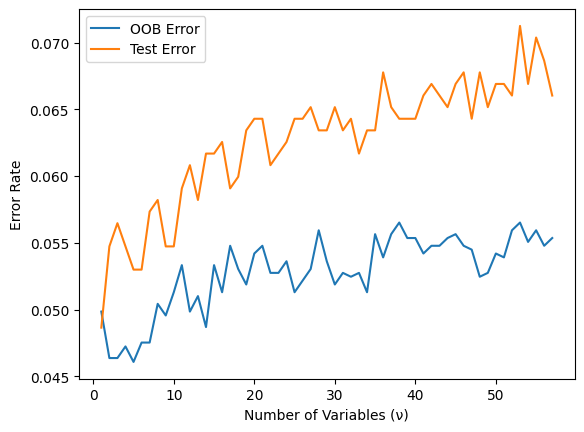

In [51]:
# Plot OOB and test errors
plt.plot(range(1, X.shape[1] + 1), oob_errors, label="OOB Error")
plt.plot(range(1, X.shape[1] + 1), test_errors, label="Test Error")
plt.xlabel("Number of Variables (ν)")
plt.ylabel("Error Rate")
plt.legend()
plt.show()

In [68]:
# Extract only non-spam (label 0) emails from the training data for one-class SVM
X_train_non_spam = X_train[y_train['Class'] == 0]

In [69]:
X_train_non_spam

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total
2641,0.00,0.39,0.19,0.0,0.19,0.09,0.0,0.00,0.00,0.00,...,0.00,1.353,0.080,0.0,0.016,0.000,0.0,1.679,17,178
2303,0.00,0.00,0.74,0.0,0.00,0.00,0.0,0.00,0.00,0.00,...,2.22,0.000,0.000,0.0,0.000,0.000,0.0,2.595,31,122
3308,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.83,1.66,...,0.00,0.000,0.118,0.0,0.000,0.000,0.0,1.475,11,59
2574,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,...,0.00,0.000,1.257,0.0,0.000,0.000,0.0,3.333,11,30
3072,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,...,0.00,0.000,0.000,0.0,0.666,0.000,0.0,1.222,3,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4211,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,...,0.00,0.000,0.331,0.0,0.331,0.000,0.0,1.714,4,24
3227,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,...,0.00,0.000,0.000,0.0,0.000,0.000,0.0,1.961,11,51
2450,0.10,0.00,0.21,0.0,0.00,0.00,0.0,0.21,0.31,0.10,...,0.00,0.043,0.143,0.0,0.000,0.057,0.0,2.409,23,571
1989,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,...,0.00,0.000,0.000,0.0,0.000,0.000,0.0,1.625,6,13


In [70]:
print(f"Number of non-spam samples in training set: {X_train_non_spam.shape[0]}")

Number of non-spam samples in training set: 2107


In [71]:
# Check for NaN values
print("NaN values in X_train_non_spam:", X_train_non_spam.isna().sum().sum())
print("NaN values in X_test:", X_test.isna().sum().sum())

NaN values in X_train_non_spam: 0
NaN values in X_test: 0


In [72]:
# Standardize the data
scaler = StandardScaler()
X_train_non_spam_scaled = scaler.fit_transform(X_train_non_spam)
X_test_scaled = scaler.transform(X_test)

In [73]:
# Parameter grid for gamma and nu
param_grid = {
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'nu': [0.01, 0.05, 0.1, 0.2, 0.3]
}

In [85]:
def misclassification_error(y_true, y_pred):
    # Convert -1 predictions (outliers) to 1 (spam) and 1 predictions (inliers) to 0 (non-spam)
    y_pred = np.where(y_pred == -1, 1, 0)
    return np.mean(y_pred != y_true)  # Calculate misclassification error rate

# Wrap the custom scoring function with `make_scorer`
misclassification_scorer = make_scorer(misclassification_error, greater_is_better=False)

In [87]:
# Set up GridSearchCV with accuracy scoring
grid_search = GridSearchCV(
    OneClassSVM(kernel='rbf'),
    param_grid=param_grid,
    scoring=misclassification_scorer,
    cv=[(np.arange(len(X_train_non_spam_scaled)), np.arange(len(X_test_scaled)))],
    refit=True,
    verbose = 3
)

In [88]:
    # Train on non-spam data
grid_search.fit(X_train_non_spam_scaled, np.zeros(X_train_non_spam_scaled.shape[0]))

Fitting 1 folds for each of 30 candidates, totalling 30 fits
[CV 1/1] END .............gamma=scale, nu=0.01;, score=-0.064 total time=   0.0s
[CV 1/1] END .............gamma=scale, nu=0.05;, score=-0.063 total time=   0.0s
[CV 1/1] END ..............gamma=scale, nu=0.1;, score=-0.114 total time=   0.0s
[CV 1/1] END ..............gamma=scale, nu=0.2;, score=-0.207 total time=   0.0s
[CV 1/1] END ..............gamma=scale, nu=0.3;, score=-0.299 total time=   0.0s
[CV 1/1] END ..............gamma=auto, nu=0.01;, score=-0.064 total time=   0.0s
[CV 1/1] END ..............gamma=auto, nu=0.05;, score=-0.063 total time=   0.0s
[CV 1/1] END ...............gamma=auto, nu=0.1;, score=-0.114 total time=   0.0s
[CV 1/1] END ...............gamma=auto, nu=0.2;, score=-0.207 total time=   0.0s
[CV 1/1] END ...............gamma=auto, nu=0.3;, score=-0.299 total time=   0.0s
[CV 1/1] END .............gamma=0.001, nu=0.01;, score=-0.005 total time=   0.0s
[CV 1/1] END .............gamma=0.001, nu=0.05;,

GridSearchCV(cv=[(array([   0,    1,    2, ..., 2104, 2105, 2106]),
                  array([   0,    1,    2, ..., 1148, 1149, 1150]))],
             estimator=OneClassSVM(),
             param_grid={'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
                         'nu': [0.01, 0.05, 0.1, 0.2, 0.3]},
             scoring=make_scorer(misclassification_error, greater_is_better=False, response_method='predict'),
             verbose=3)

In [98]:

# Get the best parameters and accuracy score
best_params = grid_search.best_params_
best_misclassification_error = -grid_search.best_score_

print("Best Parameters:", best_params)
print(f"Best Miclassification Error Rate: {best_misclassification_error:.4f}")

Best Parameters: {'gamma': 0.001, 'nu': 0.01}
Best Miclassification Error Rate: 0.0052


In [103]:
# Calculate misclassification error on test set
y_pred = grid_search.predict(X_test_scaled)
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [106]:
# Get unique values and their counts
unique_values, counts = np.unique(y_pred, return_counts=True)

# Print the results
for value, count in zip(unique_values, counts):
    print(f'Value: {value}, Count: {count}')

Value: -1, Count: 58
Value: 1, Count: 1093


In [104]:
y_test

,Class
268,1
2726,0
3220,0
462,1
748,1
...,...
3901,0
1155,1
370,1
2266,0


In [105]:
miclassification_rate = misclassification_error(y_test['Class'], y_pred)

print(f"Misclassification TestError Rate: {miclassification_rate:.4f}")

Misclassification TestError Rate: 0.3649


In [115]:
# I'm going to use an alternate method to grid search to see if we can get a better result

gammas = ['scale', 'auto', 0.001, 0.01, 0.1, 1]
nus = [0.01, 0.05, 0.1, 0.2, 0.3]

best_misclassification_rate = float('inf')
best_gamma, best_nu = None, None

In [116]:

for param1, param2 in product(gammas, nus):
    
    svm = OneClassSVM(kernel='rbf', gamma=param1, nu=param2)
    svm.fit(X_train_non_spam_scaled, np.zeros(X_train_non_spam_scaled.shape[0]))
    y_pred_svm = svm.predict(X_test_scaled)
    
    misclassification_rate_svm =  misclassification_error(y_test['Class'], y_pred_svm)
    print(f'Gamma: {param1}, nu: {param2}, Misclassification Rate: {misclassification_rate_svm:.4f}')
    
    if misclassification_rate_svm < best_misclassification_rate:
        best_misclassification_rate = misclassification_rate_svm
        best_gamma = param1
        best_nu = param2
    
    




Gamma: scale, nu: 0.01, Misclassification Rate: 0.2381
Gamma: scale, nu: 0.05, Misclassification Rate: 0.2363
Gamma: scale, nu: 0.1, Misclassification Rate: 0.2398
Gamma: scale, nu: 0.2, Misclassification Rate: 0.2563
Gamma: scale, nu: 0.3, Misclassification Rate: 0.2659
Gamma: auto, nu: 0.01, Misclassification Rate: 0.2381
Gamma: auto, nu: 0.05, Misclassification Rate: 0.2363
Gamma: auto, nu: 0.1, Misclassification Rate: 0.2398
Gamma: auto, nu: 0.2, Misclassification Rate: 0.2563
Gamma: auto, nu: 0.3, Misclassification Rate: 0.2659
Gamma: 0.001, nu: 0.01, Misclassification Rate: 0.3649
Gamma: 0.001, nu: 0.05, Misclassification Rate: 0.3076
Gamma: 0.001, nu: 0.1, Misclassification Rate: 0.2589
Gamma: 0.001, nu: 0.2, Misclassification Rate: 0.2598
Gamma: 0.001, nu: 0.3, Misclassification Rate: 0.2719
Gamma: 0.01, nu: 0.01, Misclassification Rate: 0.2763
Gamma: 0.01, nu: 0.05, Misclassification Rate: 0.2780
Gamma: 0.01, nu: 0.1, Misclassification Rate: 0.2511
Gamma: 0.01, nu: 0.2, Miscla

In [117]:
# print best params
print(f'Best Gamma: {best_gamma}, Best nu: {best_nu}, Lowest Misclassification Rate: {best_misclassification_rate:.4f}')

Best Gamma: scale, Best nu: 0.05, Lowest Misclassification Rate: 0.2363


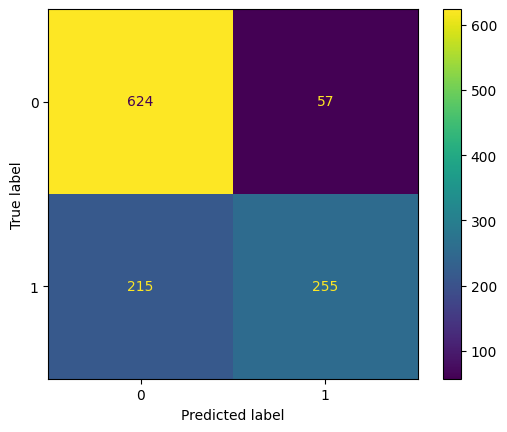

In [179]:
svm = OneClassSVM(kernel='rbf', gamma=best_gamma, nu=best_nu)
svm.fit(X_train_non_spam_scaled, np.zeros(X_train_non_spam_scaled.shape[0]))
y_pred_svm = svm.predict(X_test_scaled)

y_pred_svm = np.where(y_pred_svm == -1, 1, 0)
cm = confusion_matrix(y_test['Class'], y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# 4. Locally weighted linear regression and bias-variance tradeoff

In [119]:
# load in the data

data = loadmat('data.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACA64, Created on: Sat Mar  9 13:58:30 2024',
 '__version__': '1.0',
 '__globals__': [],
 'data': array([[-4.00000000e+00,  5.37667140e-02],
        [-3.96000000e+00,  1.71518293e-01],
        [-3.92000000e+00, -2.48052750e-01],
        [-3.88000000e+00,  5.53129160e-02],
        [-3.84000000e+00, -6.21358801e-03],
        [-3.80000000e+00, -1.74504830e-01],
        [-3.76000000e+00, -9.12121302e-02],
        [-3.72000000e+00, -1.61892973e-02],
        [-3.68000000e+00,  3.06296398e-01],
        [-3.64000000e+00,  2.25805271e-01],
        [-3.60000000e+00, -1.84236694e-01],
        [-3.56000000e+00,  2.57609499e-01],
        [-3.52000000e+00,  3.14865985e-02],
        [-3.48000000e+00, -4.10772633e-02],
        [-3.44000000e+00,  4.44267384e-02],
        [-3.40000000e+00, -3.83886058e-02],
        [-3.36000000e+00, -1.97304028e-02],
        [-3.32000000e+00,  1.53639457e-01],
        [-3.28000000e+00,  1.58957593e-01],
        [-3.240000

In [126]:
x = data['data'][:,0:1]
y = data['data'][:,1:]

In [128]:
y

array([[ 5.37667140e-02],
       [ 1.71518293e-01],
       [-2.48052750e-01],
       [ 5.53129160e-02],
       [-6.21358801e-03],
       [-1.74504830e-01],
       [-9.12121302e-02],
       [-1.61892973e-02],
       [ 3.06296398e-01],
       [ 2.25805271e-01],
       [-1.84236694e-01],
       [ 2.57609499e-01],
       [ 3.14865985e-02],
       [-4.10772633e-02],
       [ 4.44267384e-02],
       [-3.83886058e-02],
       [-1.97304028e-02],
       [ 1.53639457e-01],
       [ 1.58957593e-01],
       [ 1.74545769e-01],
       [ 1.16125713e-01],
       [-5.42569803e-02],
       [ 1.57086681e-01],
       [ 2.68601993e-01],
       [ 1.76017185e-01],
       [ 2.53469301e-01],
       [ 2.46872705e-01],
       [ 1.69325444e-01],
       [ 2.55832331e-01],
       [ 1.75772008e-01],
       [ 3.72663563e-01],
       [ 1.99698461e-01],
       [ 2.39346810e-01],
       [ 2.98348435e-01],
       [ 1.19159552e-01],
       [ 5.92930029e-01],
       [ 5.18318606e-01],
       [ 4.48206944e-01],
       [ 6.9

In [129]:
# define gaussian kernel function
def gaussian_kernel(z, h):
    p = len(z)  
    norm_squared = np.dot(z, z.T)  
    coefficient = 1 / ((np.sqrt(2 * np.pi) * h) ** p)
    exponent = np.exp(-norm_squared / (2 * h ** 2))
    
    return coefficient * exponent

In [130]:
def locally_weighted_linear_regression(x_query, X, y, h):
    n, p = X.shape[0], X.shape[1]
    
    # Construct X matrix with an intercept term
    X_intercept = np.hstack((np.ones((n, 1)), X))
    
    # Calculate weights W using Gaussian kernel
    weights = np.array([gaussian_kernel(x_query - X[i], h) for i in range(n)])
    W = np.diag(weights)
    
    # Compute (XT * W*X)^-1 *XT *W * Y
    XtWX = X_intercept.T @ W @ X_intercept
    XtWY = X_intercept.T @ W @ y
    beta = np.linalg.pinv(XtWX) @ XtWY  
    
    # 
    x_query_intercept = np.hstack((1, x_query))
    y_pred = x_query_intercept @ beta
    
    return y_pred, beta

In [145]:
# Cross-validation for tuning h
def cross_validation(X, y, h_values):
    kf = KFold(n_splits=5, shuffle=True, random_state=6740)
    cv_errors = []
    
    for h in h_values:
        fold_errors = []
        for train_index, val_index in kf.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]
            
            # Compute predictions and errors for each point in the validation set
            errors = []
            for i in range(len(X_val)):
                y_pred = locally_weighted_linear_regression(X_val[i], X_train, y_train, h)[0]
                errors.append((y_val[i] - y_pred) ** 2)
            
            # Average error for the current fold
            fold_errors.append(np.mean(errors))
        
        # Average error across all folds for current h
        cv_errors.append(np.mean(fold_errors))
    
    return cv_errors

In [146]:
# Range of bandwidth h values to test
h_values = np.linspace(0.01, 1.0, 20)

In [147]:
# Perform cross-validation
cv_errors = cross_validation(x, y, h_values)

In [148]:
# Find optimal h
optimal_h = h_values[np.argmin(cv_errors)]
print("Optimal bandwidth h:", optimal_h)

Optimal bandwidth h: 0.21842105263157896


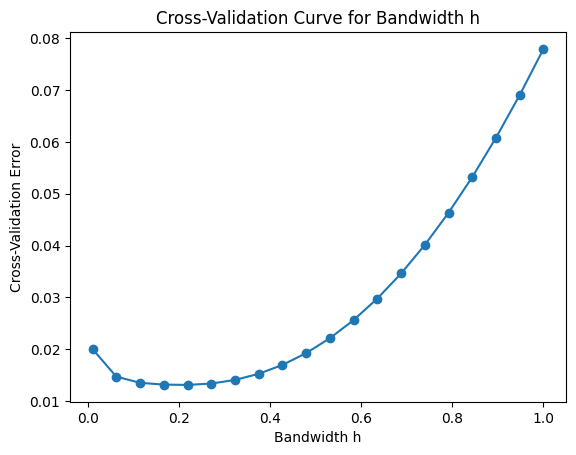

In [149]:
# Plot cross-validation curve
plt.plot(h_values, cv_errors, marker='o')
plt.xlabel('Bandwidth h')
plt.ylabel('Cross-Validation Error')
plt.title('Cross-Validation Curve for Bandwidth h')
plt.show()

In [161]:
x_pred = -1.5

y_pred = locally_weighted_linear_regression(x_pred, x, y, optimal_h)[0]

In [162]:
optimal_h

np.float64(0.21842105263157896)

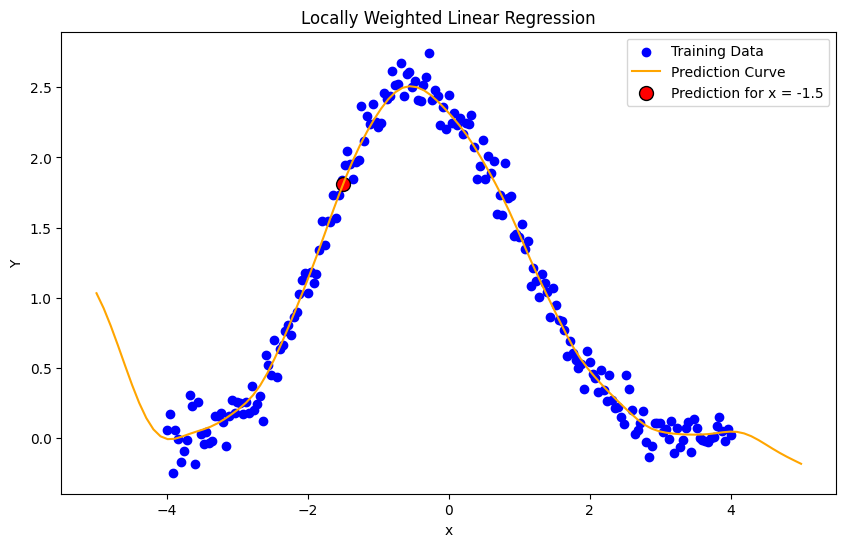

In [167]:
# Plotting the training data and the prediction
plt.figure(figsize=(10, 6))

# Plot training data
plt.scatter(x, y, color='blue', label='Training Data')

# Plot the prediction curve
# For a smoother prediction curve, we can evaluate the prediction over a range of x values
x_range = np.linspace(x.min() - 1, x.max() + 1, 100)
y_range = [locally_weighted_linear_regression(x_val, x, y, optimal_h)[0] for x_val in x_range]
plt.plot(x_range, y_range, color='orange', label='Prediction Curve')

# Mark the prediction point
plt.scatter(x_pred, y_pred, color='red', label='Prediction for x = -1.5', s=100, edgecolor='black')

# Add labels and legend
plt.title('Locally Weighted Linear Regression')
plt.xlabel('x')
plt.ylabel('Y')
plt.legend()
plt.show()

In [166]:

# Print the predicted y value
print(f'The predicted y value for x = {x_pred} is {y_pred[0]:.4f}')

The predicted y value for x = -1.5 is 1.8105
